# Pipeline for High-z Radio Galaxies 16: AGN/Galaxy classification

## Introduction

Training for classification of AGN and galaxies will be done in the HETDEX Field.  

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and galaxies from  
spectroscopically detected sources in SDSS DR16 (Spectral Class = "GALAXY").

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc
from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
# from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [8]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(stretch=PowerStretch(0.35))

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title, fontsize=14)
    plt.tight_layout()

In [9]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [10]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [11]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [12]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

Get estimators list

In [13]:
def get_base_estimators_names(pycaret_pipeline):
    if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
        estimators  = pycaret_pipeline['trained_model'].estimators
    else:
        estimators  = pycaret_pipeline.estimators

    estimators_list = [estimator[0] for estimator in estimators]
    return estimators_list

***

## Reading data

In [14]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [127]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True

In [16]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [17]:
mqc_version = '7_4d'  # '7_2'

In [18]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [19]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'zsp', 'X_ray_detect', 'radio_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag',\
                     'W2mag', 'spCl', 'FUVmag', 'NUVmag'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [20]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [21]:
# full_catalog_df.describe()

#### Select only confirmed galaxies and AGN

In [22]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]

In [23]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, and {n_is_gal} are identified as galaxies.')

In this dataset, with 83409 elements,
28251 of them are marked as AGN, and 55158 are identified as galaxies.


---

## Possible correlations

In [24]:
print(full_catalog_df.columns.to_list())

['band_num', 'is_str', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4']


---

## Random seed

In [25]:
seed = 42

Create target

$0$ for galaxies and $1$ for AGN

In [26]:
full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

Remove intermediate targets

In [27]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'is_str'])

## Split data: Test, Train, Validation

In [28]:
train_test_df, validation_df = train_test_split(full_catalog_df, test_size=0.2, random_state=seed, stratify=full_catalog_df.loc[:, 'class'])
# data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
# data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (83409, 80)
Data for Modeling (Train and Test): (66727, 80)
Unseen Data For Validation: (16682, 80)
----------------------------------------


Save indices of sources in validation sub-set for future steps.

In [29]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_01.txt', X=val_idx, header='Indices from first AGN training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [30]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [31]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [32]:
rsd_vals

K_W3        1316.463046
z_y          222.813278
i_z          211.438786
class        139.729050
i_y          123.281109
r_i          113.100182
y_W2         112.056846
g_r           96.045245
r_z           88.503172
y_W1          87.222912
z_W2          85.550365
r_y           79.287827
g_i           74.159637
z_W1          73.260473
g_z           69.627585
i_W2          68.403402
H_W3          67.093097
g_y           66.576281
i_W1          63.665291
r_W1          58.382172
r_W2          55.954758
g_W1          51.957239
J_W3          49.779707
y_J           47.047555
g_W2          46.142799
W1_W3         43.490649
y_H           42.508673
z_J           42.017880
J_H           41.547040
i_J           38.644800
z_H           38.292910
r_J           37.311930
y_K           37.136689
i_H           35.475580
y_W3          35.297026
r_H           34.765387
g_J           34.321636
z_K           34.051694
H_K           33.241848
W2_W3         32.481121
g_H           32.441469
z_W3          32

In [33]:
correlation = norm_train_test_df.corr()

In [34]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [35]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [36]:
target_feat = 'class'

In [37]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [38]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [39]:
list_drop_corr

['g_H',
 'r_H',
 'y_H',
 'i_H',
 'z_H',
 'J_W1',
 'J_W2',
 'g_K',
 'gmag',
 'r_K',
 'rmag',
 'i_K',
 'y_K',
 'z_K',
 'imag',
 'ymag',
 'zmag',
 'W1mproPM',
 'H_W1',
 'W2mproPM',
 'K_W1',
 'g_W4',
 'J_W3',
 'H_W2',
 'r_W4',
 'K_W2',
 'Jmag',
 'i_W4',
 'y_W4',
 'z_W4',
 'J_W4',
 'g_W2',
 'g_W3',
 'W1_W4',
 'r_W3',
 'r_W2',
 'y_W3',
 'W2_W4',
 'i_W3',
 'z_W3',
 'W3mag',
 'g_y',
 'Kmag',
 'H_W3',
 'g_z',
 'J_K',
 'z_J',
 'i_W1',
 'Hmag',
 'z_W1',
 'y_W1',
 'W2_W3',
 'r_J',
 'g_W1',
 'W3_W4',
 'i_J',
 'z_W2',
 'K_W4',
 'H_W4',
 'r_y',
 'i_W2',
 'g_i',
 'band_num']

In [40]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [41]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [42]:
corr_discard = norm_train_test_discard.corr()

In [43]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

W4mag  W4mag    1.000000
class  W1_W2    0.789702
r_i    r_z      0.707557
y_J    y_W2     0.684981
g_J    r_W1     0.677932
r_W1   r_z      0.652444
       r_i      0.617072
K_W3   W4mag    0.592406
W1_W2  W1_W3    0.581923
i_z    i_y      0.574151
i_y    z_y      0.562290
W1_W3  y_J      0.558754
g_J    r_z      0.538505
y_J    g_J      0.536845
r_W1   W1_W2    0.516092
dtype: float64

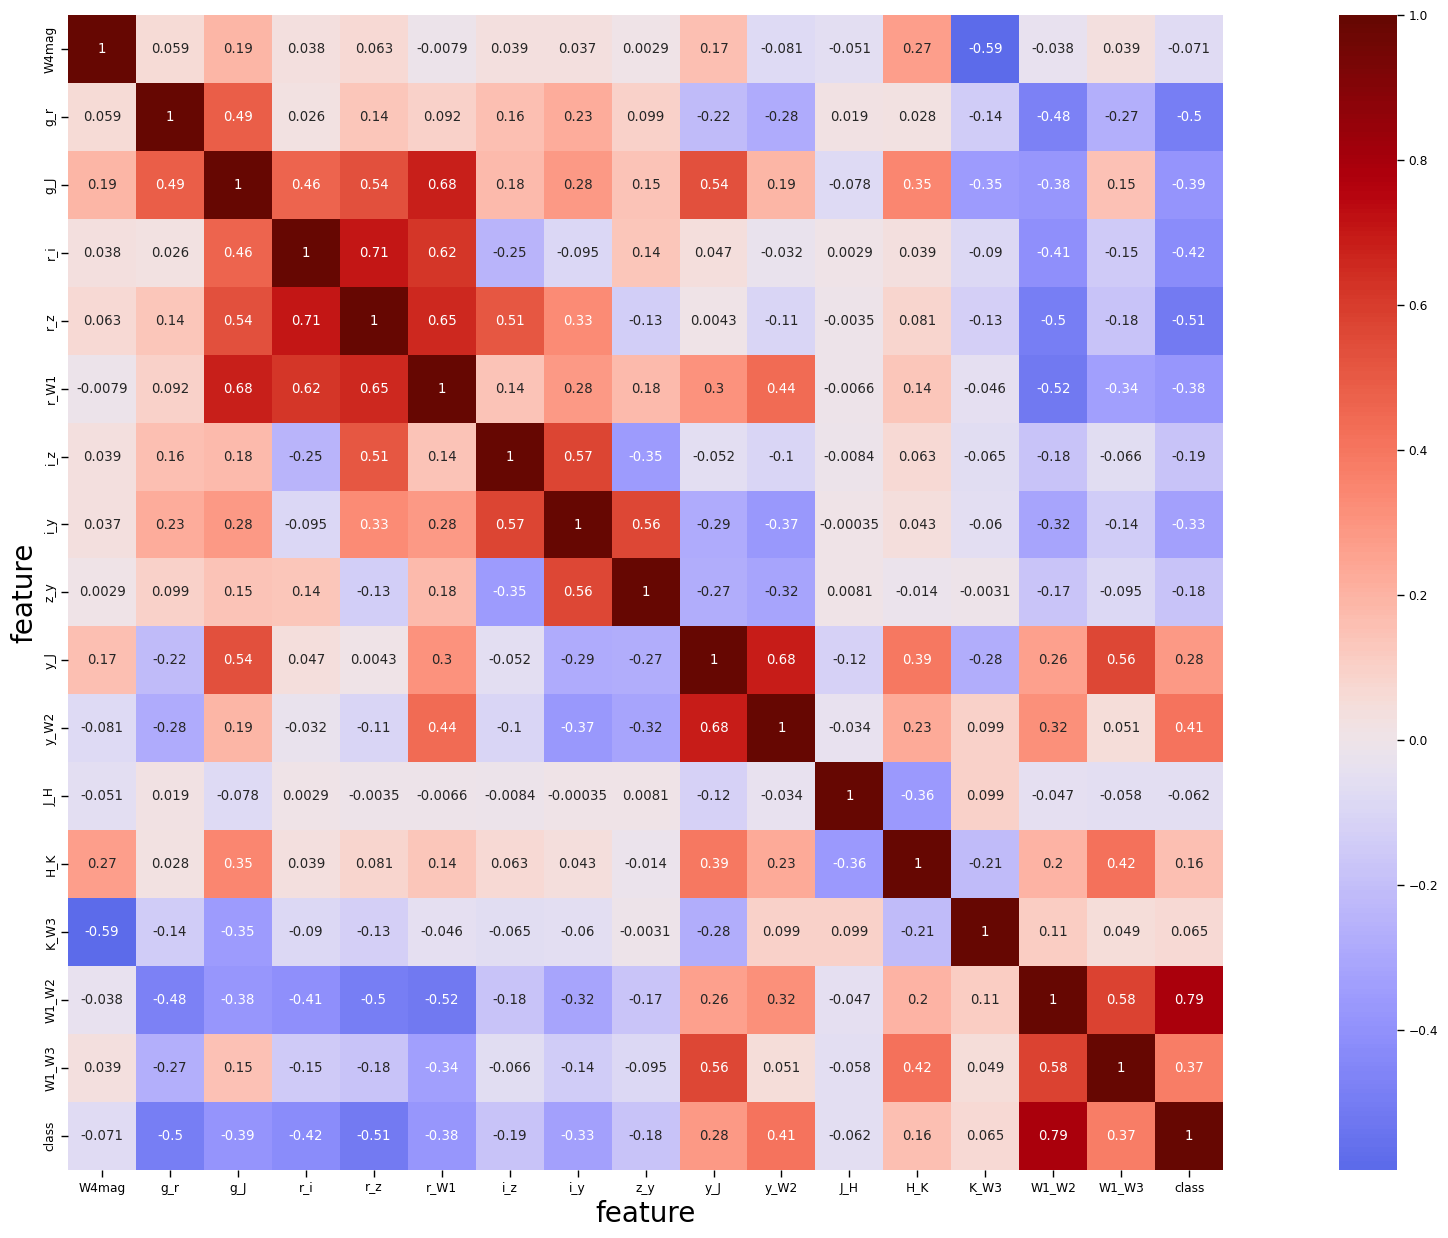

In [44]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')
plt.show()

In [45]:
norm_train_test_discard.loc[:, 'class'] = norm_train_test_discard.loc[:, 'class'].astype(bool)

In [46]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [47]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x      y    
H_K    H_K      1.000000
W1_W2  class    0.725646
g_r    class    0.575152
r_z    class    0.525163
r_i    class    0.518954
class  W1_W2    0.483988
r_z    r_i      0.374167
r_i    r_z      0.367000
J_H    H_K      0.348840
i_y    class    0.280602
g_J    class    0.265828
y_W2   class    0.254440
class  r_z      0.250037
       g_r      0.242430
r_W1   class    0.236589
W1_W3  class    0.234030
g_r    g_J      0.228937
i_z    class    0.221771
class  r_i      0.215503
r_z    r_W1     0.204538
dtype: float64

In [48]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [49]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [50]:
target_feat = 'class'

In [51]:
list_drop_pps = []

In [52]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [53]:
list_drop_pps

[]

In [54]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [55]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'class', random_seed=seed)

In [56]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,W1_W2,class,0.725646,classification,True,weighted F1,0.544,0.874894,DecisionTreeClassifier()
1,g_r,class,0.575152,classification,True,weighted F1,0.544,0.806269,DecisionTreeClassifier()
2,r_z,class,0.525163,classification,True,weighted F1,0.544,0.783474,DecisionTreeClassifier()
3,r_i,class,0.518954,classification,True,weighted F1,0.544,0.780643,DecisionTreeClassifier()
4,i_y,class,0.280602,classification,True,weighted F1,0.544,0.671954,DecisionTreeClassifier()
5,g_J,class,0.265828,classification,True,weighted F1,0.544,0.665218,DecisionTreeClassifier()
6,y_W2,class,0.254440,classification,True,weighted F1,0.544,0.660025,DecisionTreeClassifier()
7,r_W1,class,0.236589,classification,True,weighted F1,0.544,0.651885,DecisionTreeClassifier()
8,W1_W3,class,0.234030,classification,True,weighted F1,0.544,0.650718,DecisionTreeClassifier()
9,i_z,class,0.221771,classification,True,weighted F1,0.544,0.645128,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [57]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = pps_pred_target.x.to_list()  # After Boruta

In [58]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [59]:
exp_AGN = pyc.setup(data=train_test_df, target='class', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta', data_split_stratify=True,\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(66727, 80)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [60]:
pyc.get_config('X').columns

Index(['W4mag', 'g_r', 'g_J', 'r_i', 'r_z', 'r_W1', 'i_z', 'i_y', 'z_y', 'y_J',
       'y_W2', 'J_H', 'H_K', 'K_W3', 'W1_W2', 'W1_W3'],
      dtype='object')

In [61]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [62]:
metric_to_optimize   = 'Recall'

In [63]:
final_selection_clf  = ['catboost', 'lightgbm', 'xgboost', 'et', 'lda', 'dummy']  # knn, qda, nb lack feat importances neither coefs, ridge lacks scores
n_models             = 5
# top_model_AGN = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort=metric_to_optimize)  # 1:15 hour for used_models_clf
top_model_AGN = pyc.compare_models(n_select=n_models, exclude=['knn', 'qda', 'ridge', 'nb'], sort=metric_to_optimize)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9566,0.9872,0.9245,0.9461,0.9352,0.9025,0.9027,1.7150
lightgbm,Light Gradient Boosting Machine,0.9555,0.9867,0.9233,0.9440,0.9336,0.9001,0.9002,27.9910
xgboost,Extreme Gradient Boosting,0.9548,0.9861,0.9214,0.9439,0.9325,0.8986,0.8987,9.0880
lda,Linear Discriminant Analysis,0.9382,0.9725,0.9197,0.9000,0.9097,0.8627,0.8629,0.0290
et,Extra Trees Classifier,0.9543,0.9847,0.9185,0.9450,0.9316,0.8973,0.8975,0.2300
gbc,Gradient Boosting Classifier,0.9528,0.9847,0.9170,0.9422,0.9294,0.8940,0.8942,1.8440
rf,Random Forest Classifier,0.9545,0.9849,0.9169,0.9470,0.9317,0.8976,0.8979,0.8490
svm,SVM - Linear Kernel,0.9435,0.0000,0.9150,0.9180,0.9164,0.8737,0.8738,0.0340
lr,Logistic Regression,0.9454,0.9789,0.9149,0.9234,0.9191,0.8779,0.8780,0.2960
ada,Ada Boost Classifier,0.9464,0.9813,0.9093,0.9308,0.9199,0.8796,0.8798,0.4030


Thus, we select `catboost` as meta learner.

Then, we stack the models.

In [64]:
stacked_model_AGN = pyc.stack_models(estimator_list=top_model_AGN[1:], meta_model=top_model_AGN[0],\
                                     optimize=metric_to_optimize, restack=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9576,0.9881,0.9260,0.9476,0.9367,0.9048,0.9050
1,0.9568,0.9856,0.9273,0.9440,0.9356,0.9030,0.9031
2,0.9572,0.9885,0.9279,0.9447,0.9362,0.9040,0.9041
3,0.9540,0.9858,0.9210,0.9418,0.9313,0.8967,0.8968
4,0.9503,0.9836,0.9128,0.9389,0.9256,0.8884,0.8886
5,0.9589,0.9909,0.9273,0.9501,0.9386,0.9077,0.9078
6,0.9570,0.9887,0.9279,0.9441,0.9359,0.9035,0.9036
7,0.9531,0.9837,0.9090,0.9504,0.9292,0.8942,0.8947
8,0.9587,0.9869,0.9317,0.9455,0.9386,0.9074,0.9075


In [65]:
tuned_AGN_clf = pyc.tune_model(stacked_model_AGN, early_stopping='asha', optimize=metric_to_optimize,\
                               search_library='tune-sklearn', search_algorithm='random')  # 20  minutes

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9572,0.9886,0.9298,0.9429,0.9363,0.9041,0.9041
1,0.9540,0.9850,0.9273,0.9362,0.9317,0.8970,0.8970
2,0.9565,0.9871,0.9267,0.9440,0.9352,0.9025,0.9026
3,0.9544,0.9854,0.9248,0.9396,0.9321,0.8978,0.8979
4,0.9505,0.9826,0.9153,0.9372,0.9261,0.8890,0.8891
5,0.9617,0.9905,0.9305,0.9552,0.9427,0.9139,0.9141
6,0.9576,0.9881,0.9324,0.9419,0.9371,0.9051,0.9052
7,0.9505,0.9834,0.9090,0.9430,0.9257,0.8886,0.8890
8,0.9559,0.9874,0.9324,0.9371,0.9347,0.9014,0.9014


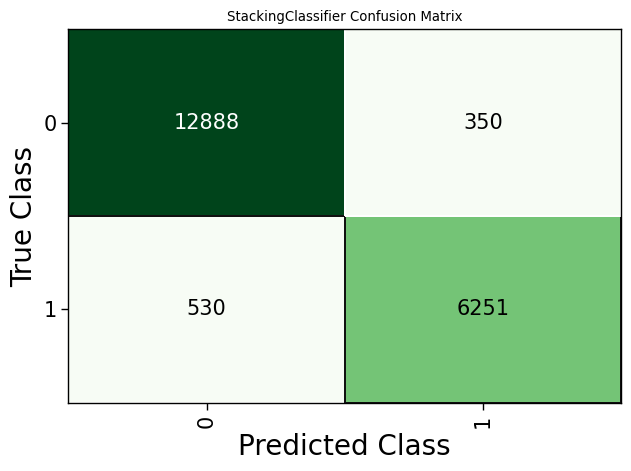

In [66]:
pyc.plot_model(tuned_AGN_clf, plot='confusion_matrix')

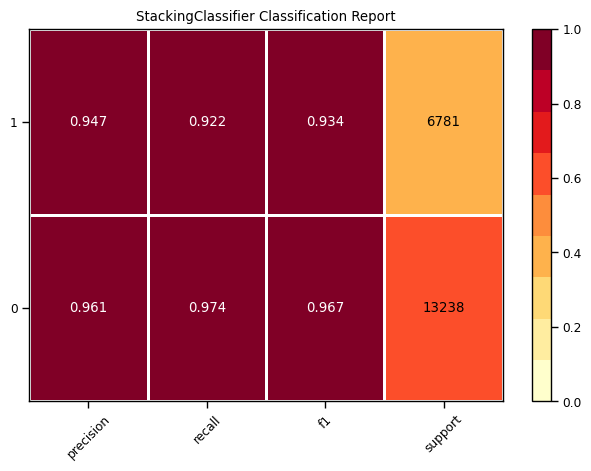

In [67]:
pyc.plot_model(tuned_AGN_clf, plot='class_report')

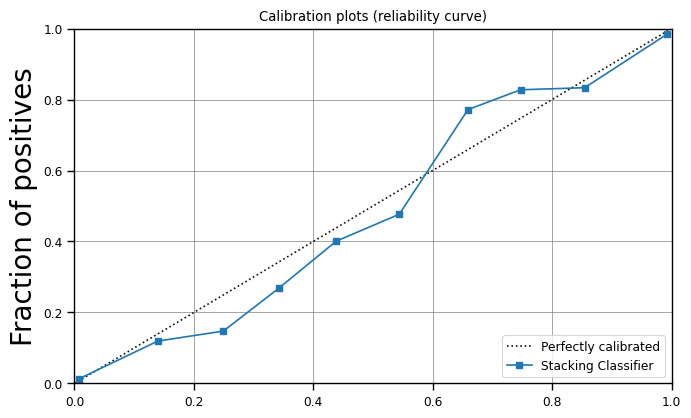

In [68]:
pyc.plot_model(tuned_AGN_clf, plot='calibration')

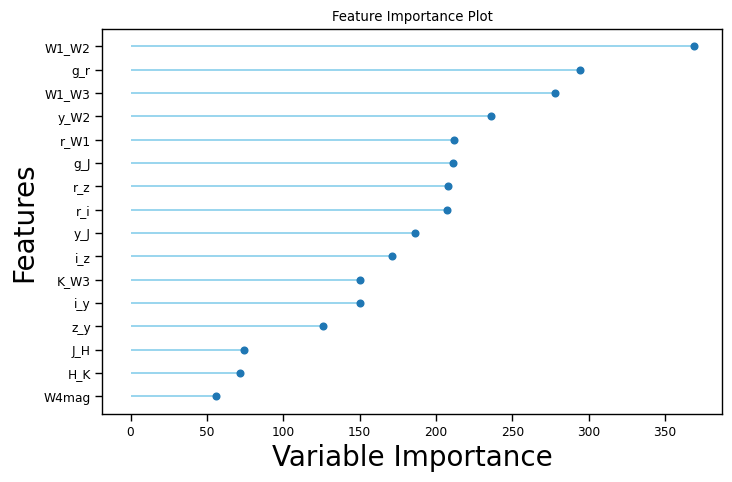

In [69]:
pyc.plot_model(tuned_AGN_clf.estimators_[0], plot='feature_all')

In [70]:
pyc.plot_model(tuned_AGN_clf.final_estimator, plot='parameter')

,Parameters
depth,4
l2_leaf_reg,10
border_count,254
thread_count,12
verbose,False
random_strength,0.1
task_type,CPU
n_estimators,250
random_state,42
eta,1e-06


In [71]:
plt.rcParams.update(plt.rcParamsDefault)

In [72]:
pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9560,0.9866,0.9218,0.9470,0.9342,0.9012,0.9014


,W4mag,g_r,g_J,r_i,r_z,r_W1,i_z,i_y,z_y,y_J,y_W2,J_H,H_K,K_W3,W1_W2,W1_W3,class,Label,Score_0,Score_1
0,0.203476,-0.909306,1.362859,1.900373,0.180170,1.535885,-2.125167,-0.797723,1.326741,1.555014,1.167916,-0.057689,0.341686,-0.186100,0.008473,0.624694,0,0,0.5002,0.4998
1,0.203476,-0.909306,1.362859,4.734768,4.457156,2.482112,-0.229706,-0.618724,-0.503299,-0.482435,-0.025983,-0.057689,0.341686,-0.186100,-0.526906,-0.981497,0,0,0.5003,0.4997
2,0.203476,1.055331,1.362859,0.833891,0.825564,1.329601,0.119860,0.803535,0.780200,0.180739,0.120251,-0.057689,0.341686,-0.186100,-1.400363,-0.701908,0,0,0.5003,0.4997
3,0.203476,0.084916,-1.188885,-0.381363,-0.155411,-0.509739,0.233426,0.189893,-0.031357,-1.653904,-0.881210,-1.012535,-2.088938,-0.186100,-0.551824,-1.754004,0,0,0.5002,0.4998
4,0.203476,0.368085,0.438748,0.078551,0.211085,0.282011,0.203901,0.329061,0.158581,0.247838,-0.317697,-0.057689,0.341686,-0.186100,-0.608496,0.063009,0,0,0.5003,0.4997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20014,0.203476,5.108469,1.807368,-2.276982,-7.147516,-0.994708,-5.782312,-4.789446,1.326741,1.971665,2.804432,-3.149022,-1.970056,1.735617,-0.786813,-0.301176,0,0,0.5003,0.4997
20015,0.203476,-0.852289,-0.153575,-0.173296,0.062627,0.505969,0.298063,0.791075,0.597696,0.232133,0.292168,-0.057689,0.341686,-0.186100,0.410254,-0.132365,1,1,0.4998,0.5002
20016,0.203476,-0.681301,0.064693,-0.379270,-0.710961,-0.677978,-0.521249,-1.498256,-1.222103,1.555014,0.889966,-0.057689,0.341686,-0.186100,1.144382,1.619318,1,1,0.4999,0.5001
20017,0.203476,1.286856,1.362859,0.826689,0.936072,1.048951,0.294969,0.406554,0.159972,0.234299,-0.179289,-0.057689,0.341686,-0.186100,-1.837136,-0.471788,0,0,0.5003,0.4997


In [73]:
test_prediction_clf = pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9560,0.9866,0.9218,0.9470,0.9342,0.9012,0.9014


In [74]:
final_AGN_clf = pyc.finalize_model(tuned_AGN_clf)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the a

In [75]:
if save_model_flag:
    pyc.save_model(final_AGN_clf, 'models/classification_AGN_galaxy_ago_03_2022')  # Model (it will be saved with .pkl extension) classification_AGN_galaxy_may_15_2022
    # pyc.save_config('../../models/config_classification_AGN_galaxy_ago_03_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [57]:
if load_model_flag:
    if use_5sigma:
        final_AGN_clf = pyc.load_model('models/classification_AGN_galaxy_ago_03_2022')

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [77]:
estimators_list = get_base_estimators_names(final_AGN_clf)

In [78]:
extended_data_AGN = validation_df.loc[:, get_final_column_names(final_AGN_clf, validation_df)].copy()
extended_idx_AGN  = extended_data_AGN.index
initial_cols_AGN  = extended_data_AGN.columns
extended_cols_AGN = extended_data_AGN.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_AGN = extended_cols_AGN.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [79]:
print('Running data pre-processing:\n')
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    prep_steps = final_AGN_clf.named_steps.items()
else:
    prep_steps = pyc.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_AGN = method.transform(extended_data_AGN)
extended_data_AGN_df = pd.DataFrame(extended_data_AGN, columns=extended_cols_AGN, index=extended_idx_AGN)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [80]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    if hasattr(final_AGN_clf.named_steps['trained_model'].final_estimator_, 'feature_importances_'):
        importances_coef = final_AGN_clf.named_steps['trained_model'].final_estimator_.feature_importances_
    elif hasattr(final_AGN_clf.named_steps['trained_model'].final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_AGN_clf.named_steps['trained_model'].final_estimator_.coef_)) *\
                                     extended_data_AGN.loc[:, extended_cols_AGN].std(axis=0)
else:
    if hasattr(final_AGN_clf.final_estimator_, 'feature_importances_'):
        importances_coef = final_AGN_clf.final_estimator_.feature_importances_
    elif hasattr(final_AGN_clf.final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_AGN_clf.final_estimator_.coef_)) *\
                                     extended_data_AGN.loc[:, extended_cols_AGN].std(axis=0)

coef_meta_df = pd.DataFrame({'Feature': extended_cols_AGN, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [81]:
if isinstance(final_AGN_clf, sklearn.pipeline.Pipeline):
    estimators_list  = final_AGN_clf.named_steps['trained_model'].estimators
    estimators_list_ = final_AGN_clf.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_AGN_clf.estimators
    estimators_list_ = final_AGN_clf.estimators_

In [82]:
base_models_names = [model[0] for model in estimators_list]

In [83]:
coef_sorted_base_df = {}

In [84]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_AGN.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_AGN.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
        )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_AGN.drop(base_models_names),
                                     'Importance': np.abs(model_fit.coef_.ravel()) *\
                                     extended_data_AGN_df.loc[:, extended_cols_AGN.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_AGN.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
        )

In [85]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [86]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for lightgbm...
Calculating for xgboost...
Calculating for lda...
Calculating for et...


lightgbm            xgboost                lda                 et  \
    Feature Importance Feature Importance Feature Importance Feature   
0     W1_W2    12.8667   W1_W2    57.1925     g_J    18.0389   W1_W2   
1     W1_W3     9.9667     r_z    14.0645     y_J    16.2276     g_J   
2       g_r     8.8667    y_W2     5.5225     i_y    12.2609    y_W2   
3      y_W2     7.5000   W1_W3     3.2774    r_W1    10.9391     g_r   
4       r_z     7.0333     g_J     2.7987    y_W2     9.9986     r_z   
5       g_J     6.7333   W4mag     2.7193     g_r     6.8948    r_W1   
6       r_i     6.6333     H_K     2.4923     r_i     5.6671     r_i   
7      r_W1     6.5000     g_r     2.2694   W1_W2     5.1325   W1_W3   
8       y_J     5.9333    K_W3     1.7277     i_z     4.9428     y_J   
9       i_z     5.7333     r_i     1.5034     r_z     4.8361     i_y   
10     K_W3     5.5333    r_W1     1.2512   W1_W3     2.7449     i_z   
11      i_y     5.4333     y_J     1.2431   W4mag     1.1595     z_y   
12      z_y     4.2667     i_y     1.0696     H_K     0.4983    K_W3   
13      H_K     2.6667     J_H     1.0221    K_W3     0.4465     H_K   
14      J_H     2.4000     i_z     0.9923     z_y     0.1114   W4mag   
15    W4mag     1.9333     z_y     0.8540     J_H     0.1006     J_H   

               
   Importance  
0     36.7164  
1      7.9522  
2      7.9461  
3      7.4842  
4      6.8763  
5      6.1847  
6      5.8132  
7      5.4368  
8      4.8309  
9      2.8582  
10     2.3462  
11     1.8143  
12     1.2834  
13     0.8514  
14     0.8213  
15     0.7843

In [125]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
with pd.option_context('display.float_format', '{:.4e}'.format):
    display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,et,5.5282e+01
1,lda,2.9995e+01
2,lightgbm,1.4621e+01
3,H_K,4.4000e-02
4,y_J,2.8062e-02
5,W4mag,1.6268e-02
6,g_r,9.2508e-03
7,W1_W2,4.6300e-03
8,r_W1,0.0000e+00
9,xgboost,0.0000e+00


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
W1_W2	12.889
W1_W3	9.963
g_r	8.864
y_W2	7.499
r_z	7.036
g_J	6.732
r_i	6.631
r_W1	6.498
y_J	5.931
i_z	5.731
K_W3	5.531
i_y	5.431
z_y	4.265
H_K	2.666
J_H	2.399
W4mag	1.933


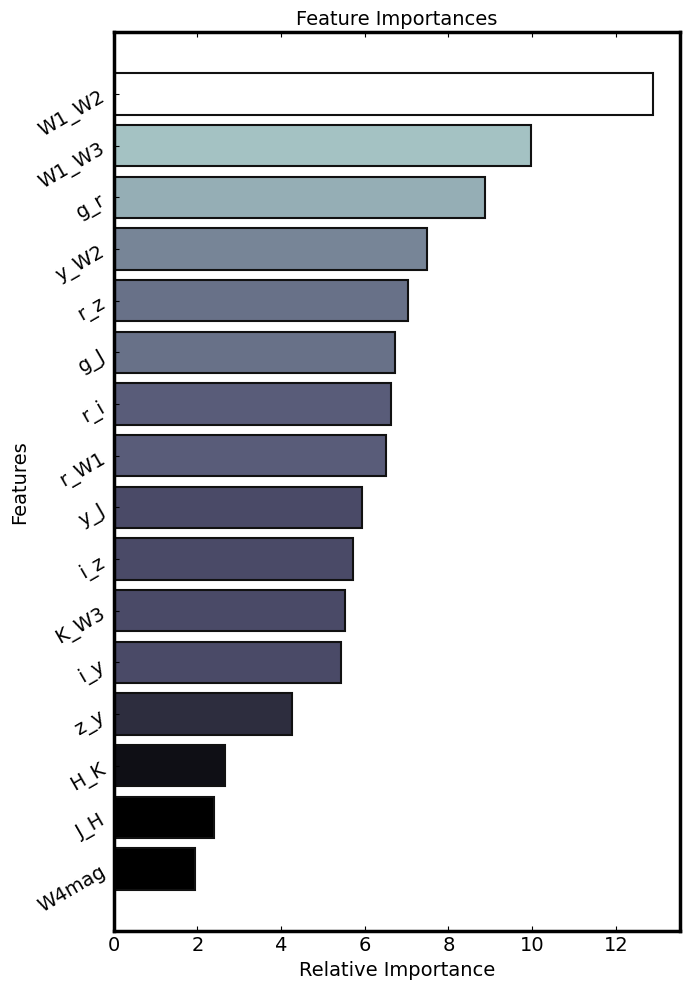

In [88]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_AGN_clf, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_classification_AGN_galaxy_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

---

In [89]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['class']), train_test_df.loc[:, 'class'], False, 'class'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['class']),
                train_test_df.loc[:, 'class'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

#### Calculate optimal threshold for classification

In [90]:
AGN_naive_threshold       = 0.5

In [91]:
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df, probability_threshold=AGN_naive_threshold, raw_score=True, round=10)
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_data_df, probability_threshold=AGN_naive_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_data_df,  probability_threshold=AGN_naive_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df, probability_threshold=AGN_naive_threshold, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9577388802,0.9887836671,0.9286725664,0.9455757794,0.9370479507,0.9052449420,0.9053283610


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9759570095,0.9987185441,0.9472459759,0.9814971659,0.9640674495,0.9460106008,0.9463475321


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9766721614,0.9987454862,0.9492309990,0.9804133251,0.9645702147,0.9471885927,0.9474634937


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9761715647,0.9987265281,0.9478341666,0.9811752851,0.9642165909,0.9463634341,0.9466811923


#### Naive threshold metrics.

In [92]:
cm_mat_val_naive = np.array([[np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
                              np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
                             [np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
                              np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

In [93]:
cm_mat_train_naive = np.array([[np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
                                np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
                               [np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
                                np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

In [94]:
cm_mat_test_naive = np.array([[np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
                              [np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

In [95]:
cm_mat_train_test_naive = np.array([[np.sum(np.array(train_test_prediction_clf['class'] == 0) & np.array(train_test_prediction_clf['Label'] == 0)),\
                                     np.sum(np.array(train_test_prediction_clf['class'] == 0) & np.array(train_test_prediction_clf['Label'] == 1))],\
                                    [np.sum(np.array(train_test_prediction_clf['class'] == 1) & np.array(train_test_prediction_clf['Label'] == 0)),\
                                     np.sum(np.array(train_test_prediction_clf['class'] == 1) & np.array(train_test_prediction_clf['Label'] == 1))]])

In [96]:
MCC_val_naive           = MCC_from_CM(cm_mat_val_naive)
ACC_val_naive           = ACC_from_CM(cm_mat_val_naive)
F1_val_naive            = F1_from_CM(cm_mat_val_naive)
Recall_val_naive        = Recall_from_CM(cm_mat_val_naive)

MCC_train_naive         = MCC_from_CM(cm_mat_train_naive)
ACC_train_naive         = ACC_from_CM(cm_mat_train_naive)
F1_train_naive          = F1_from_CM(cm_mat_train_naive)
Recall_train_naive      = Recall_from_CM(cm_mat_train_naive)

MCC_test_naive          = MCC_from_CM(cm_mat_test_naive)
ACC_test_naive          = ACC_from_CM(cm_mat_test_naive)
F1_test_naive           = F1_from_CM(cm_mat_test_naive)
Recall_test_naive       = Recall_from_CM(cm_mat_test_naive)

MCC_train_test_naive    = MCC_from_CM(cm_mat_train_test_naive)
ACC_train_test_naive    = ACC_from_CM(cm_mat_train_test_naive)
F1_train_test_naive     = F1_from_CM(cm_mat_train_test_naive)
Recall_train_test_naive = Recall_from_CM(cm_mat_train_test_naive)

naive_scores_array            = np.array([[F1_train_naive,      MCC_train_naive,      Recall_train_naive,      ACC_train_naive],\
                                          [F1_test_naive,       MCC_test_naive,       Recall_test_naive,       ACC_test_naive],\
                                          [F1_train_test_naive, MCC_train_test_naive, Recall_train_test_naive, ACC_train_test_naive],\
                                          [F1_val_naive,        MCC_val_naive,        Recall_val_naive,        ACC_val_naive]])

In [97]:
naive_scores_df = pd.DataFrame(data=naive_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'], index=['Train', 'Test', 'Train+Test', 'Validation'])

In [98]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df)

,F1,MCC,Recall,ACC
Train,0.9641,0.9463,0.9472,0.9760
Test,0.9646,0.9475,0.9492,0.9767
Train+Test,0.9642,0.9467,0.9478,0.9762
Validation,0.9370,0.9053,0.9287,0.9577


#### Calibration curve

In [99]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, 'class'],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, 'class'],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=20, normalize=True)  # calibration_curve(y_test, prob_pos, n_bins=10)

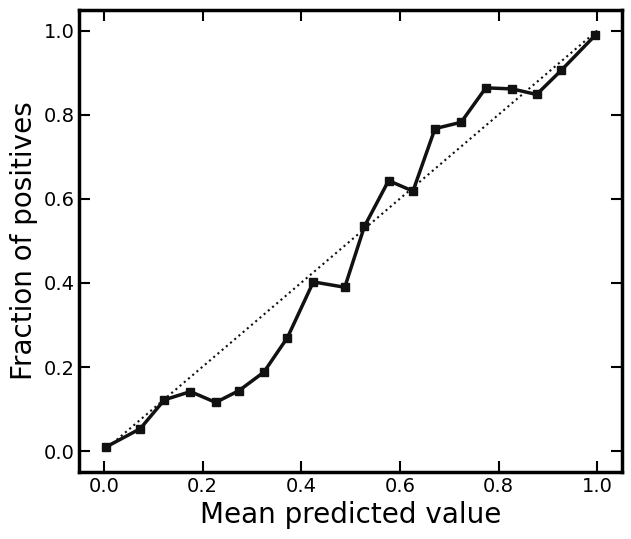

In [100]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='s', c='k', lw=2.5)
ax1.plot([0, 1], [0, 1], ls=':', c='k', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()

Calculate ROC AUC values and plots.

In [101]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, 'class'],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, 'class'],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, 'class'], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, 'class'], validation_prediction_clf.loc[:, 'Score_1'])

In [102]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.99872
Area under the curve (ROC) for test       = 0.99875
Area under the curve (ROC) for train+test = 0.99873
Area under the curve (ROC) for validation = 0.98878


In [103]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, 'class'],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, 'class'],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, 'class'], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, 'class'], validation_prediction_clf.loc[:, 'Score_1'])

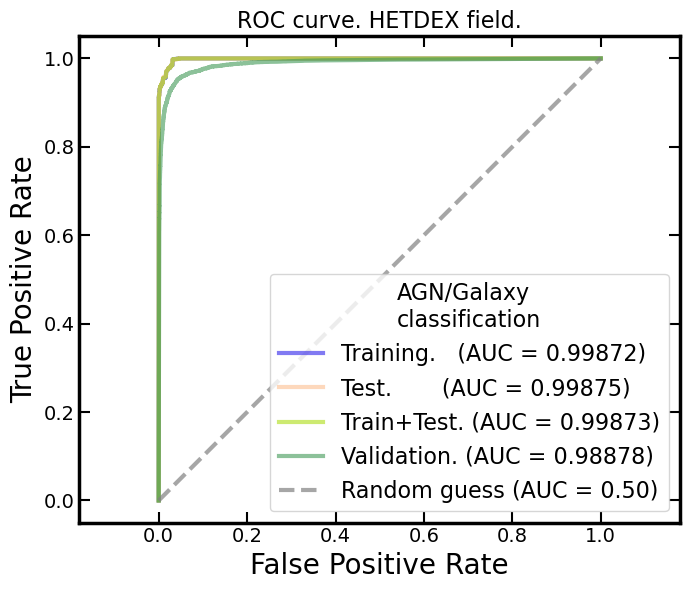

In [104]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test. (AUC = {roc_auc_train_test:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='AGN/Galaxy\nclassification', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/AUC_ROC_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

##### Find optimal threshold for each sub-set

In [105]:
opt_t_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_t_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_t_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_t_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [106]:
print(f'Optimal threshold from area under the curve (ROC) for training   = {opt_t_train:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for test       = {opt_t_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for train+test = {opt_t_train_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for validation = {opt_t_validation:.5f}')

Optimal threshold from area under the curve (ROC) for training   = 0.49989
Optimal threshold from area under the curve (ROC) for test       = 0.49989
Optimal threshold from area under the curve (ROC) for train+test = 0.49989
Optimal threshold from area under the curve (ROC) for validation = 0.49994


##### Precision-Recall curve

In [107]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, 'class'],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, 'class'],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, 'class'],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, 'class'],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [108]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_validation = auc(recall_validation, prec_validation)

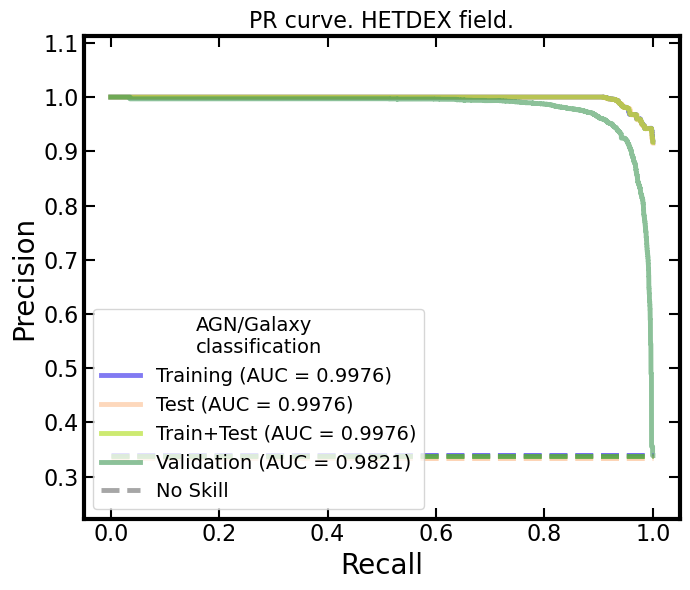

In [109]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test (AUC = {auc_pr_train_test:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Validation (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, 'class'] == 1)      / len(train_prediction_clf.loc[:, 'class'])
no_skill_test       = np.sum(test_prediction_clf.loc[:, 'class'] == 1)       / len(test_prediction_clf.loc[:, 'class'])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, 'class'] == 1) / len(train_test_prediction_clf.loc[:, 'class'])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, 'class'] == 1) / len(validation_prediction_clf.loc[:, 'class'])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='AGN/Galaxy\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/PR_curve_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [110]:
fscore_train      = (2 * prec_train      * recall_train)      / (prec_train      + recall_train)
fscore_test       = (2 * prec_test       * recall_test)       / (prec_test       + recall_test)
fscore_train_test = (2 * prec_train_test * recall_train_test) / (prec_train_test + recall_train_test)
fscore_validation = (2 * prec_validation * recall_validation) / (prec_validation + recall_validation)

In [111]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [112]:
print(f'Optimal threshold from Precision-Recall curve for training   = {opt_t_PR_train:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test       = {opt_t_PR_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test = {opt_t_PR_train_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation = {opt_t_PR_validation:.5f}')

Optimal threshold from Precision-Recall curve for training   = 0.49989
Optimal threshold from Precision-Recall curve for test       = 0.49995
Optimal threshold from Precision-Recall curve for train+test = 0.49989
Optimal threshold from Precision-Recall curve for validation = 0.49999


---

In [113]:
AGN_pred_threshold = float(opt_t_PR_train_test) #  0.46759

In [114]:
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df, probability_threshold=AGN_pred_threshold, raw_score=True)
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_data_df, probability_threshold=AGN_pred_threshold, raw_score=True)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_data_df,  probability_threshold=AGN_pred_threshold, raw_score=True)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df, probability_threshold=AGN_pred_threshold, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9439,0.9888,0.9660,0.8800,0.9210,0.8777,0.8800


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9783,0.9987,0.9974,0.9423,0.9691,0.9524,0.9533


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9785,0.9987,0.9975,0.9418,0.9688,0.9525,0.9534


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9784,0.9987,0.9974,0.9422,0.9690,0.9524,0.9533


Create confusion matrices.

In [115]:
cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
                          np.sum(np.array(train_prediction_clf['class'] == 0) & np.array(train_prediction_clf['Label'] == 1))],\
                         [np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
                          np.sum(np.array(train_prediction_clf['class'] == 1) & np.array(train_prediction_clf['Label'] == 1))]])

cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
                         np.sum(np.array(test_prediction_clf['class'] == 0) & np.array(test_prediction_clf['Label'] == 1))],\
                        [np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
                         np.sum(np.array(test_prediction_clf['class'] == 1) & np.array(test_prediction_clf['Label'] == 1))]])

cm_mat_train_test = np.array([[np.sum(np.array(train_test_prediction_clf['class'] == 0) & np.array(train_test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(train_test_prediction_clf['class'] == 0) & np.array(train_test_prediction_clf['Label'] == 1))],\
                              [np.sum(np.array(train_test_prediction_clf['class'] == 1) & np.array(train_test_prediction_clf['Label'] == 0)),\
                               np.sum(np.array(train_test_prediction_clf['class'] == 1) & np.array(train_test_prediction_clf['Label'] == 1))]])

cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
                        np.sum(np.array(validation_prediction_clf['class'] == 0) & np.array(validation_prediction_clf['Label'] == 1))],\
                       [np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
                        np.sum(np.array(validation_prediction_clf['class'] == 1) & np.array(validation_prediction_clf['Label'] == 1))]])

In [116]:
MCC_gal_AGN_train    = MCC_from_CM(cm_mat_train)
ACC_gal_AGN_train    = ACC_from_CM(cm_mat_train)
F1_gal_AGN_train     = F1_from_CM(cm_mat_train)
Recall_gal_AGN_train = Recall_from_CM(cm_mat_train)

MCC_gal_AGN_test    = MCC_from_CM(cm_mat_test)
ACC_gal_AGN_test    = ACC_from_CM(cm_mat_test)
F1_gal_AGN_test     = F1_from_CM(cm_mat_test)
Recall_gal_AGN_test = Recall_from_CM(cm_mat_test)

MCC_gal_AGN_train_test    = MCC_from_CM(cm_mat_train_test)
ACC_gal_AGN_train_test    = ACC_from_CM(cm_mat_train_test)
F1_gal_AGN_train_test     = F1_from_CM(cm_mat_train_test)
Recall_gal_AGN_train_test = Recall_from_CM(cm_mat_train_test)

MCC_gal_AGN_val    = MCC_from_CM(cm_mat_val)
ACC_gal_AGN_val    = ACC_from_CM(cm_mat_val)
F1_gal_AGN_val     = F1_from_CM(cm_mat_val)
Recall_gal_AGN_val = Recall_from_CM(cm_mat_val)

final_scores_array      = np.array([[F1_gal_AGN_train,      MCC_gal_AGN_train,      Recall_gal_AGN_train,      ACC_gal_AGN_train],\
                                    [F1_gal_AGN_test,       MCC_gal_AGN_test,       Recall_gal_AGN_test,       ACC_gal_AGN_test],\
                                    [F1_gal_AGN_train_test, MCC_gal_AGN_train_test, Recall_gal_AGN_train_test, ACC_gal_AGN_train_test],\
                                    [F1_gal_AGN_val,        MCC_gal_AGN_val,        Recall_gal_AGN_val,        ACC_gal_AGN_val]])

In [117]:
final_scores_df = pd.DataFrame(data=final_scores_array, columns=['F1', 'MCC', 'Recall', 'ACC'], index=['Train', 'Test', 'Train+Test', 'Validation'])

In [118]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(final_scores_df)

,F1,MCC,Recall,ACC
Train,0.9691,0.9533,0.9974,0.9783
Test,0.9688,0.9534,0.9975,0.9785
Train+Test,0.9690,0.9533,0.9974,0.9784
Validation,0.9210,0.8800,0.9660,0.9439


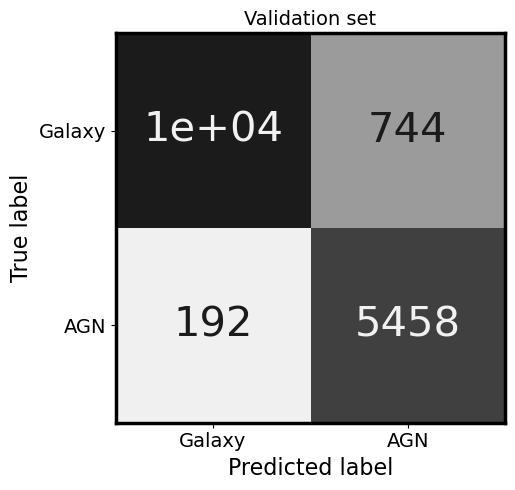

In [119]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

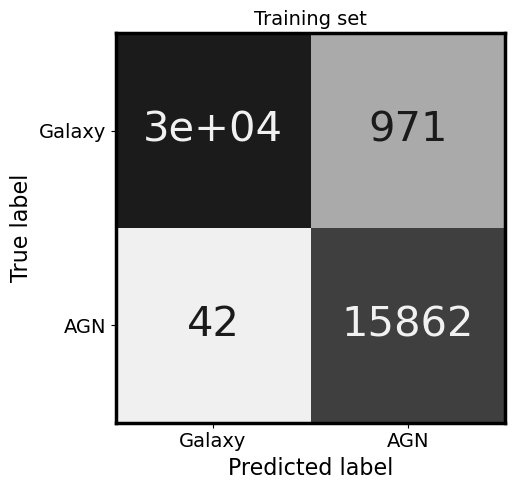

In [120]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

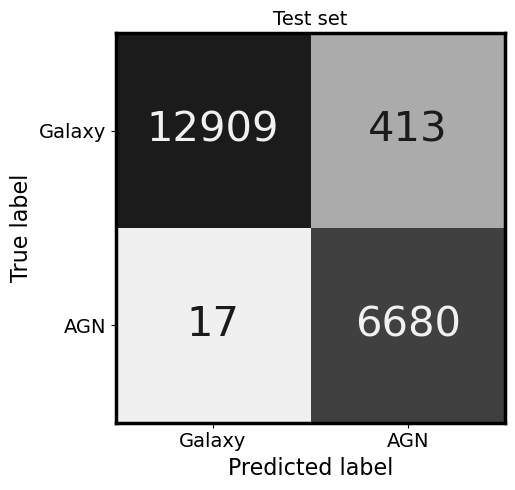

In [121]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_test_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

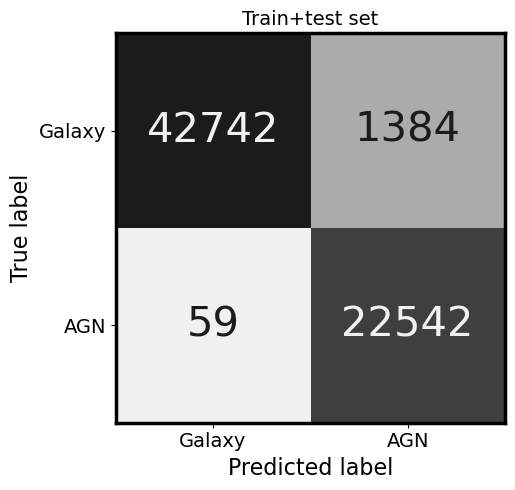

In [122]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_test_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()